In [1]:
import os
import numpy as np
import argparse
from tqdm import tqdm
import imageio
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import getpass
user = getpass.getuser()
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
alphapose_root = '/home/{}/codes/AlphaPose/'.format(user)
motionbert_root, alphapose_root

('/home/hrai/codes/MotionBERT', '/home/hrai/codes/AlphaPose/')

In [2]:
os.chdir(motionbert_root)
from lib.utils.tools import *
from lib.utils.learning import *
from lib.utils.utils_data import flip_data
from lib.data.dataset_wild import WildDetDataset
from lib.utils.vismo import render_and_save

### Load MotionBERT

In [3]:
import easydict

opts = easydict.EasyDict({
    "config": "configs/pose3d/MB_ft_h36m.yaml",
    "evaluate": "checkpoint/pose3d/MB_ft_h36m/best_epoch.bin",
    "json_path": "",
    "vid_path": "",
    "out_path": "",
    "pixel": True,
    "focus": None,
    "clip_len": 243,
    })
args = get_config(opts.config)

In [4]:
model_backbone = load_backbone(args)
if torch.cuda.is_available():
    model_backbone = nn.DataParallel(model_backbone)
    model_backbone = model_backbone.cuda()

print('Loading checkpoint', opts.evaluate)
checkpoint = torch.load(opts.evaluate, map_location=lambda storage, loc: storage)
model_backbone.load_state_dict(checkpoint['model_pos'], strict=True)
model_pos = model_backbone
model_pos.eval()
testloader_params = {
          'batch_size': 1,
          'shuffle': False,
          'num_workers': 8,
          'pin_memory': True,
          'prefetch_factor': 4,
          'persistent_workers': True,
          'drop_last': False
}

Loading checkpoint checkpoint/pose3d/MB_ft_h36m/best_epoch.bin


### Inference and Save the result

#### Single video

In [18]:
video = '30_M160A_3'
out_path = 'output/aihub/MotionBERT_{}'.format(video)
vid_path = alphapose_root + 'examples/aihub_result/res_{}/test.mp4'.format(video)
json_path = alphapose_root + 'examples/aihub_result/res_{}/alphapose-results.json'.format(video)

vid = imageio.get_reader(vid_path,  'ffmpeg')
fps_in = vid.get_meta_data()['fps']
vid_size = vid.get_meta_data()['size']
os.makedirs(out_path, exist_ok=True)

We had to kill ffmpeg to stop it.


In [19]:
fps_in, vid_size, opts.pixel

(60.0, (1920, 1080), True)

In [20]:
if opts.pixel:
    # Keep relative scale with pixel coornidates
    wild_dataset = WildDetDataset(json_path, clip_len=opts.clip_len, vid_size=vid_size, scale_range=None, focus=opts.focus)
else:
    # Scale to [-1,1]
    wild_dataset = WildDetDataset(json_path, clip_len=opts.clip_len, scale_range=[1,1], focus=opts.focus)
test_loader = DataLoader(wild_dataset, **testloader_params)

100%|██████████| 144/144 [00:13<00:00, 10.80it/s]


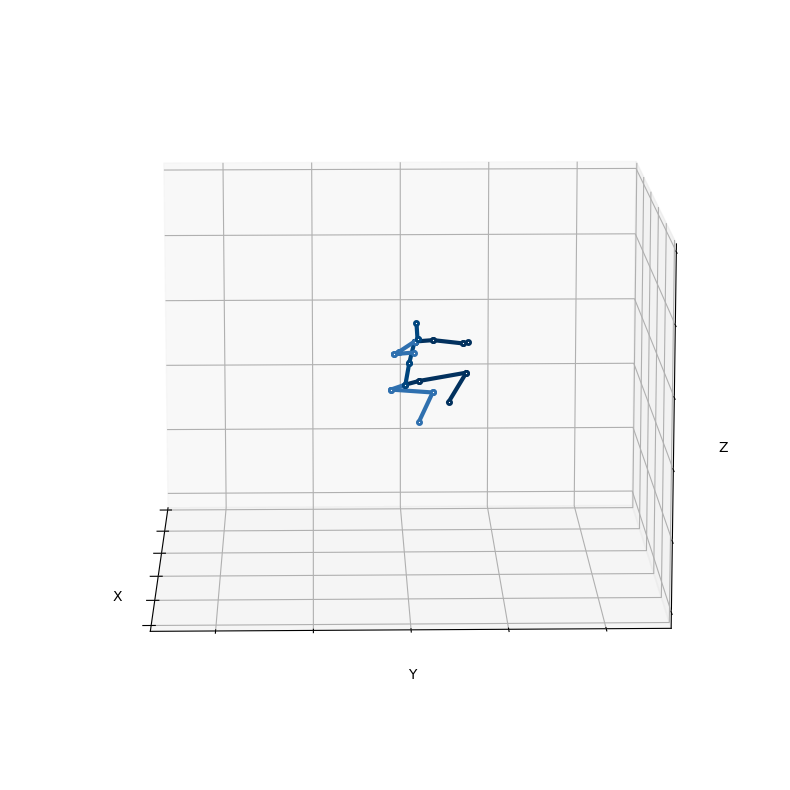

In [27]:
results_all = []
with torch.no_grad():
    for batch_input in tqdm(test_loader):
        N, T = batch_input.shape[:2]
        if torch.cuda.is_available():
            batch_input = batch_input.cuda()
        if args.no_conf:
            batch_input = batch_input[:, :, :, :2]
        if args.flip:    
            batch_input_flip = flip_data(batch_input)
            predicted_3d_pos_1 = model_pos(batch_input)
            predicted_3d_pos_flip = model_pos(batch_input_flip)
            predicted_3d_pos_2 = flip_data(predicted_3d_pos_flip) # Flip back
            predicted_3d_pos = (predicted_3d_pos_1 + predicted_3d_pos_2) / 2.0
        else:
            predicted_3d_pos = model_pos(batch_input)
        if args.rootrel:
            predicted_3d_pos[:,:,0,:]=0                    # [N,T,17,3]
        else:
            predicted_3d_pos[:,0,0,2]=0
            pass
        if args.gt_2d:
            predicted_3d_pos[...,:2] = batch_input[...,:2]
        results_all.append(predicted_3d_pos.cpu().numpy())

results_all = np.hstack(results_all) # (B, N, 17, 3)
results_all = np.concatenate(results_all) # (BxN, 17, 3)
save_path = '{}/MotionBERT_{}.mp4'.format(out_path, video)
render_and_save(results_all, save_path, keep_imgs=False, fps=fps_in)
if opts.pixel:
    # Convert to pixel coordinates
    results_all = results_all * (min(vid_size) / 2.0)
    results_all[:,:,:2] = results_all[:,:,:2] + np.array(vid_size) / 2.0
np.save('%s/MotionBERT_%s.npy' % (out_path, video), results_all)

#### Multiple videos

In [9]:
video_list = [i.split('res_')[1] for i in os.listdir("/home/hrai/codes/AlphaPose/examples/aihub_result")]
for video in video_list:
    print(video)
    out_path = 'output/aihub/MotionBERT_{}'.format(video)
    vid_path = alphapose_root + 'examples/aihub_result/res_{}/test.mp4'.format(video)
    json_path = alphapose_root + 'examples/aihub_result/res_{}/alphapose-results.json'.format(video)

    #vid = imageio.get_reader(vid_path,  'ffmpeg')
    fps_in = 60.0 #vid.get_meta_data()['fps']
    vid_size = (1920, 1080) #vid.get_meta_data()['size']
    os.makedirs(out_path, exist_ok=True)

    try:
        if opts.pixel:
            # Keep relative scale with pixel coornidates
            wild_dataset = WildDetDataset(json_path, clip_len=opts.clip_len, vid_size=vid_size, scale_range=None, focus=opts.focus)
        else:
            # Scale to [-1,1]
            wild_dataset = WildDetDataset(json_path, clip_len=opts.clip_len, scale_range=[1,1], focus=opts.focus)
        test_loader = DataLoader(wild_dataset, **testloader_params)
    except Exception as e:
        print(e)
        continue

    results_all = []
    with torch.no_grad():
        for batch_input in tqdm(test_loader):
            N, T = batch_input.shape[:2]
            if torch.cuda.is_available():
                batch_input = batch_input.cuda()
            if args.no_conf:
                batch_input = batch_input[:, :, :, :2]
            if args.flip:    
                batch_input_flip = flip_data(batch_input)
                predicted_3d_pos_1 = model_pos(batch_input)
                predicted_3d_pos_flip = model_pos(batch_input_flip)
                predicted_3d_pos_2 = flip_data(predicted_3d_pos_flip) # Flip back
                predicted_3d_pos = (predicted_3d_pos_1 + predicted_3d_pos_2) / 2.0
            else:
                predicted_3d_pos = model_pos(batch_input)
            if args.rootrel:
                predicted_3d_pos[:,:,0,:]=0                    # [N,T,17,3]
            else:
                predicted_3d_pos[:,0,0,2]=0
                pass
            if args.gt_2d:
                predicted_3d_pos[...,:2] = batch_input[...,:2]
            results_all.append(predicted_3d_pos.cpu().numpy())
    
    results_all = np.hstack(results_all) # (B, N, 17, 3)
    results_all = np.concatenate(results_all) # (BxN, 17, 3)
    save_path = '{}/MotionBERT_{}.mp4'.format(out_path, video)
    #render_and_save(results_all, '%s/X3D.mp4' % (save_path), keep_imgs=False, fps=fps_in)
    if opts.pixel:
        # Convert to pixel coordinates
        results_all = results_all * (min(vid_size) / 2.0)
        results_all[:,:,:2] = results_all[:,:,:2] + np.array(vid_size) / 2.0
    np.save('%s/MotionBERT_%s.npy' % (out_path, video), results_all)

33_F150D_5


100%|██████████| 5/5 [00:00<00:00, 16.92it/s]


33_F160D_2


100%|██████████| 4/4 [00:00<00:00, 15.44it/s]


30_F160A_1


100%|██████████| 4/4 [00:00<00:00, 16.06it/s]


33_F160D_8


100%|██████████| 4/4 [00:00<00:00, 16.31it/s]


33_M160B_5


100%|██████████| 3/3 [00:00<00:00, 13.38it/s]


33_M160D_8


100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


33_F170D_4


100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


33_F150B_5


100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


33_M160C_5


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


33_F150A_6


100%|██████████| 2/2 [00:00<00:00, 10.75it/s]


33_F150A_1


100%|██████████| 2/2 [00:00<00:00, 10.78it/s]


33_M160C_1


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


33_F170D_8


100%|██████████| 2/2 [00:00<00:00, 11.39it/s]


33_F160B_8


100%|██████████| 2/2 [00:00<00:00, 11.83it/s]


33_F150A_3


100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


33_F150B_6


100%|██████████| 3/3 [00:00<00:00, 13.89it/s]


33_M160B_2


100%|██████████| 6/6 [00:00<00:00, 18.56it/s]


33_F150A_8


100%|██████████| 3/3 [00:00<00:00, 14.44it/s]


33_M160C_8


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


33_F150B_8


100%|██████████| 2/2 [00:00<00:00, 11.33it/s]


33_F150A_5


100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


33_F160B_1


100%|██████████| 3/3 [00:00<00:00, 14.81it/s]


23_F150B_2


100%|██████████| 3/3 [00:00<00:00, 13.83it/s]


33_M160B_3


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


33_M160C_4


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


33_M160C_6


100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


33_F150D_8


100%|██████████| 2/2 [00:00<00:00, 11.51it/s]


33_F170D_6


100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


33_M160B_8


100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


33_F170D_3


100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


33_F160B_2


100%|██████████| 3/3 [00:00<00:00, 14.63it/s]


33_M160B_4


100%|██████████| 2/2 [00:00<00:00, 11.49it/s]


30_M160A_3


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


49_M170D_5


100%|██████████| 2/2 [00:00<00:00, 11.86it/s]


33_F150D_2


100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


### Rendering

In [29]:
os.chdir(motionbert_root)
import numpy as np
from lib.utils.vismo import render_and_save

In [30]:
video = '30_M160A_3'
vid_size = (1920, 1080)
result_folder = '/home/hrai/codes/MotionBERT/output/aihub/MotionBERT_{}'.format(video)
results_all = np.load(result_folder + '/MotionBERT_{}.npy'.format(video))
results_all[:,:,:2] = results_all[:,:,:2] - np.array(vid_size) / 2.0
results_all = results_all / (min(vid_size) / 2.0)

In [36]:
save_path = '{}/MotionBERT_{}.mp4'.format(result_folder, video)
fps_in=60.0
save_path


'/home/hrai/codes/MotionBERT/output/aihub/MotionBERT_30_M160A_3/MotionBERT_30_M160A_3.mp4'

  0%|          | 0/144 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (923, 924) to (928, 928) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
100%|██████████| 144/144 [00:13<00:00, 10.91it/s]


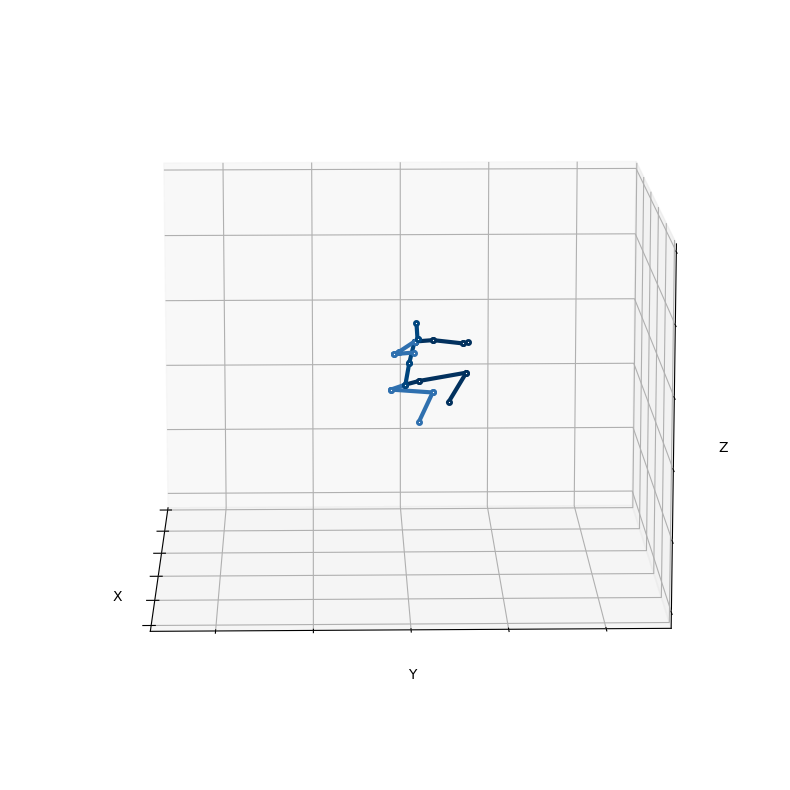

In [37]:
render_and_save(results_all, save_path, keep_imgs=False, fps=fps_in)